In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

from torchsummary import summary

In [4]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [5]:
batch_size = 64

In [6]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 29505970.31it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [8]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [9]:
print(trainset.data.shape)
print(type(trainset.data))
print(type(trainset))

(50000, 32, 32, 3)
<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


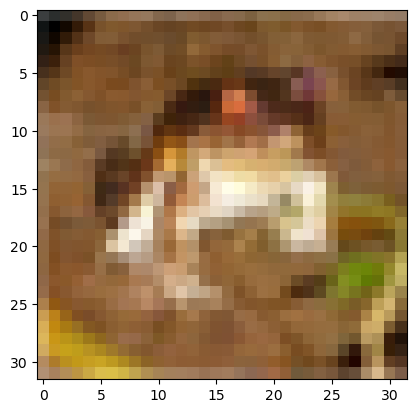

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = next(iter(trainloader))

In [11]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

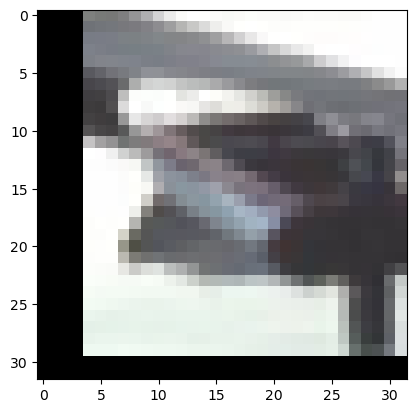

In [12]:
im[0].shape
imshow(im[0])

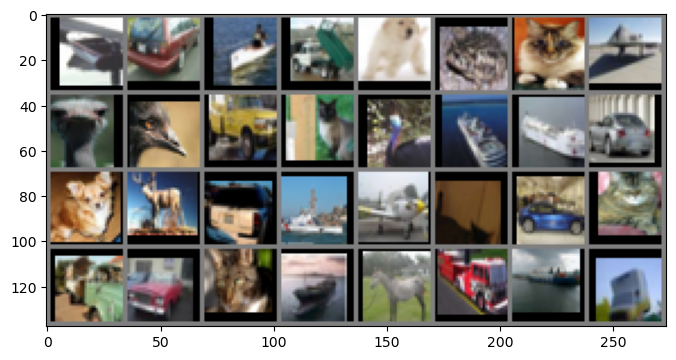

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

In [16]:
class VGG(nn.Module):
    
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(512,10),
        )
# self.classifier = nn.Linear(512,10)

        self._initialize_weight()
        
    def forward(self, x):
        out = self.features(x)
        # entering
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
    
    # make layers
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3 # RGB initial channel is 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)] # kernel_size is 2 x 2, then step size is 2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1), # are all convolution kernels of (3.3)
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)] # RelU
                in_channels = x # redefine channels
# layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    
    # Initialization parameters
    def _initialize_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # xavier is used in VGG's paper
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

In [17]:
net = VGG('VGG19').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True


In [18]:
summary(net, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 32, 32]          36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-6                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-7                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-10                        [-1, 128, 16, 16]         --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 16, 16]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 32, 32]          1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-3                         [-1, 64, 32, 32]          --
|    └─Conv2d: 2-4                       [-1, 64, 32, 32]          36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 32, 32]          128
|    └─ReLU: 2-6                         [-1, 64, 32, 32]          --
|    └─MaxPool2d: 2-7                    [-1, 64, 16, 16]          --
|    └─Conv2d: 2-8                       [-1, 128, 16, 16]         73,856
|    └─BatchNorm2d: 2-9                  [-1, 128, 16, 16]         256
|    └─ReLU: 2-10                        [-1, 128, 16, 16]         --
|    └─Conv2d: 2-11                      [-1, 128, 16, 16]         147,584
|    └─BatchNorm2d: 2-12                 [-1, 128, 16, 16]        

In [16]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 0.000001) 
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)

import time
epoch = 50

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [17]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/VGG19.pth'

The file already exists


In [18]:
def get_acc(outputs, label):
    total = outputs.shape[0]
    probs, pred_y = outputs.data.max(dim=1) 
    correct = (pred_y == label).sum().data
    return correct / total

def train(net, trainloader, testloader, epoches, optimizer , criterion, scheduler , path = './model.pth', writer = None ,verbose = False):
    best_acc = 0
    train_acc_list, test_acc_list = [],[]
    train_loss_list, test_loss_list = [],[]
    lr_list  = []
    for i in range(epoches):
        start = time.time()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        if torch.cuda.is_available():
            net = net.to(device)
        net.train()
        for step,data in enumerate(trainloader,start=0):
            im,label = data
            im = im.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
            # formard
            outputs = net(im)
            loss = criterion(outputs,label)
            # backward
            loss.backward()
            optimizer.step()

            train_loss += loss.data
            train_acc += get_acc(outputs,label)
            rate = (step + 1) / len(trainloader)
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc * 100 / len(trainloader)
        if verbose:
            train_acc_list.append(train_acc.item())
            train_loss_list.append(train_loss.item())
    #     print('train_loss:{:.6f} train_acc:{:3.2f}%' .format(train_loss ,train_acc),end=' ')  
        lr = optimizer.param_groups[0]['lr']
        if verbose:
            lr_list.append(lr)
        scheduler.step(train_loss)
        if testloader is not None:
            net.eval()
            with torch.no_grad():
                for step,data in enumerate(testloader,start=0):
                    im,label = data
                    im = im.to(device)
                    label = label.to(device)
                    if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
                    outputs = net(im)
                    loss = criterion(outputs,label)
                    test_loss += loss.data
                    test_acc += get_acc(outputs,label)
                    rate = (step + 1) / len(testloader)
                    a = "*" * int(rate * 50)
                    b = "." * (50 - int(rate * 50))
                    print('\r test  {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,epoches,int(rate*100),a,b),end='')
            test_loss = test_loss / len(testloader)
            test_acc = test_acc * 100 / len(testloader)
            if verbose:
                test_loss_list.append(test_loss.item())
                test_acc_list.append(test_acc.item())
            end = time.time()
            print(
                '\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}% Test Loss:{:>.6f}  Test Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(
                    i + 1, epoches, train_loss, train_acc, test_loss, test_acc,lr), end='')
        else:
            end = time.time()
            print('\rEpoch [{:>3d}/{:>3d}]  Train Loss:{:>.6f}  Train Acc:{:>3.2f}%  Learning Rate:{:>.6f}'.format(i+1,epoches,train_loss,train_acc,lr),end = '')
        time_ = int(end - start)
        h = time_ / 3600
        m = time_ % 3600 /60
        s = time_ % 60
        time_str = "\tTime %02d:%02d" % ( m, s)
        if writer is not None:
            writer.add_scalars('Loss', {'train': train_loss,
                                    'valid': test_loss}, i+1)
            writer.add_scalars('Acc', {'train': train_acc ,
                                   'valid': test_acc}, i+1)
            writer.add_scalars('Learning Rate',lr,i+1)
        # =========================================================
        print(time_str)
        if test_acc > best_acc:
            torch.save(net,path)
            best_acc = test_acc
    Acc = {}
    Loss = {}
    Acc['train_acc'] = train_acc_list
    Acc['test_acc'] = test_acc_list
    Loss['train_loss'] = train_loss_list
    Loss['test_loss'] = test_loss_list
    Lr = lr_list
    return Acc, Loss, Lr

In [19]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, verbose = True)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/ 50]  Train Loss:1.769362  Train Acc:30.81% Test Loss:1.408262  Test Acc:48.61%  Learning Rate:0.010000	Time 00:44
Epoch [  2/ 50]  Train Loss:1.201944  Train Acc:57.57% Test Loss:0.954643  Test Acc:66.79%  Learning Rate:0.010000	Time 00:42
Epoch [  3/ 50]  Train Loss:0.928807  Train Acc:68.49% Test Loss:0.839696  Test Acc:71.62%  Learning Rate:0.010000	Time 00:43
Epoch [  4/ 50]  Train Loss:0.776028  Train Acc:74.04% Test Loss:0.770969  Test Acc:74.54%  Learning Rate:0.010000	Time 00:42
Epoch [  5/ 50]  Train Loss:0.680312  Train Acc:77.35% Test Loss:0.682098  Test Acc:77.47%  Learning Rate:0.010000	Time 00:42
Epoch [  6/ 50]  Train Loss:0.612536  Train Acc:79.82% Test Loss:0.622052  Test Acc:79.38%  Learning Rate:0.010000	Time 00:42
Epoch [  7/ 50]  Train Loss:0.552944  Train Acc:81.73% Test Loss:0.588624  Test Acc:80.95%  Learning Rate:0.010000	Time 00:42
Epoch [  8/ 50]  Train Loss:0.511606  Train Acc:83.17% Test Loss:0.540407  Test Acc:82.55%  Learning Rate:0.010000	Tim

In [20]:
import matplotlib.pyplot as plt


def plot_history(epoches, Acc, Loss):
    plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray'

    epoch_list = range(1,epoches + 1)
    plt.plot(epoch_list, Loss['train_loss'])
    plt.plot(epoch_list, Loss['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, Acc['train_acc'])
    plt.plot(epoch_list, Acc['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('Acc Value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

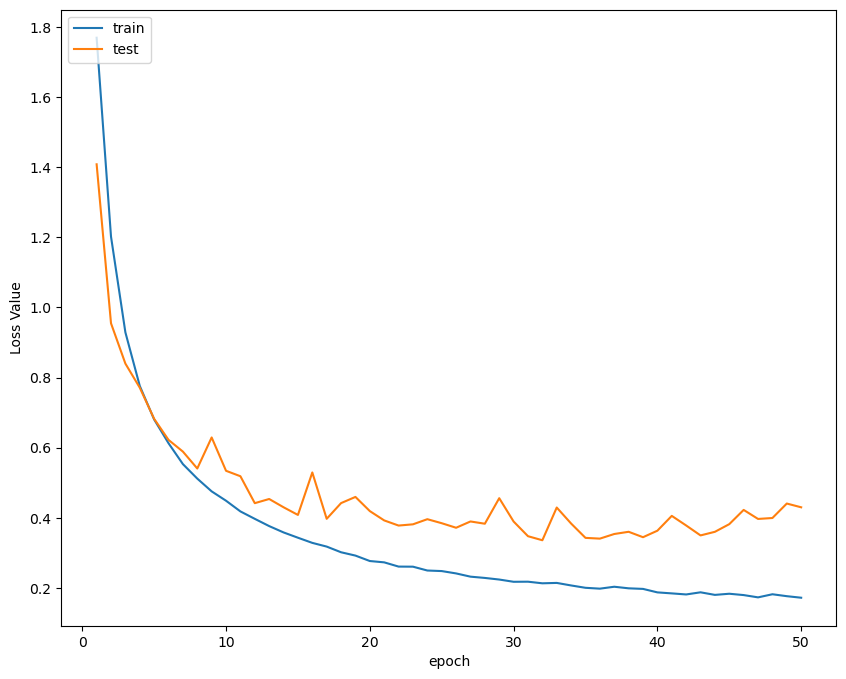

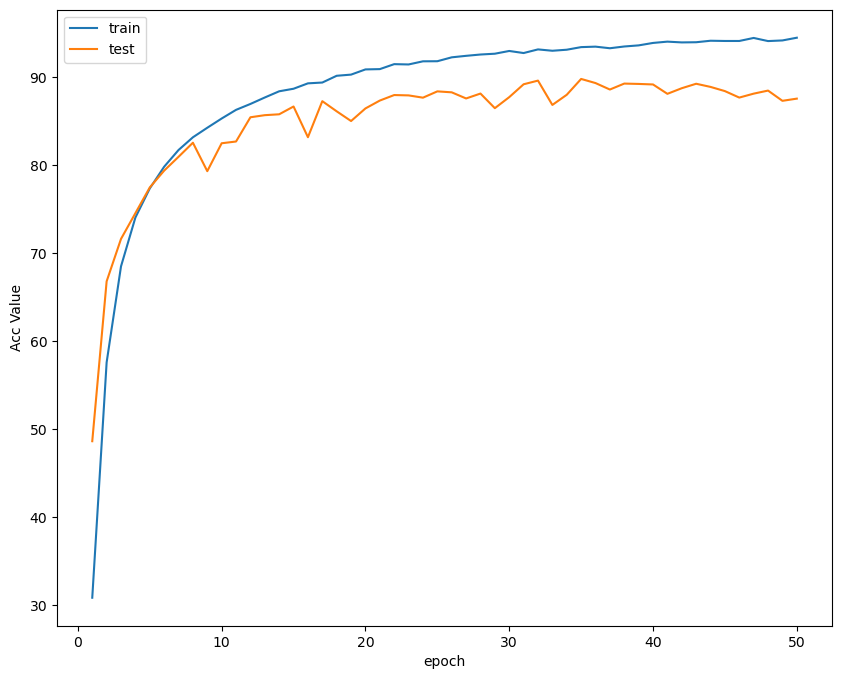

In [21]:
plot_history(epoch, Acc, Loss)

In [22]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=0)
net.eval()
for data in testloader: # Loop through each batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval() # Convert the model to test mode
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images) # Enter the network for testing
    
    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 87.60 %


In [23]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 79.70 %
Accuracy of automobile : 93.60 %
Accuracy of  bird : 85.60 %
Accuracy of   cat : 67.40 %
Accuracy of  deer : 94.60 %
Accuracy of   dog : 87.50 %
Accuracy of  frog : 88.50 %
Accuracy of horse : 93.80 %
Accuracy of  ship : 89.70 %
Accuracy of truck : 95.60 %


In [24]:
def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*1.25, len(conf_mat)*1.25)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                num = conf_mat[i, j].astype(np.int64) 
                cell_text += format(num, 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")
    
    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)
        
    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')
    return fig, ax

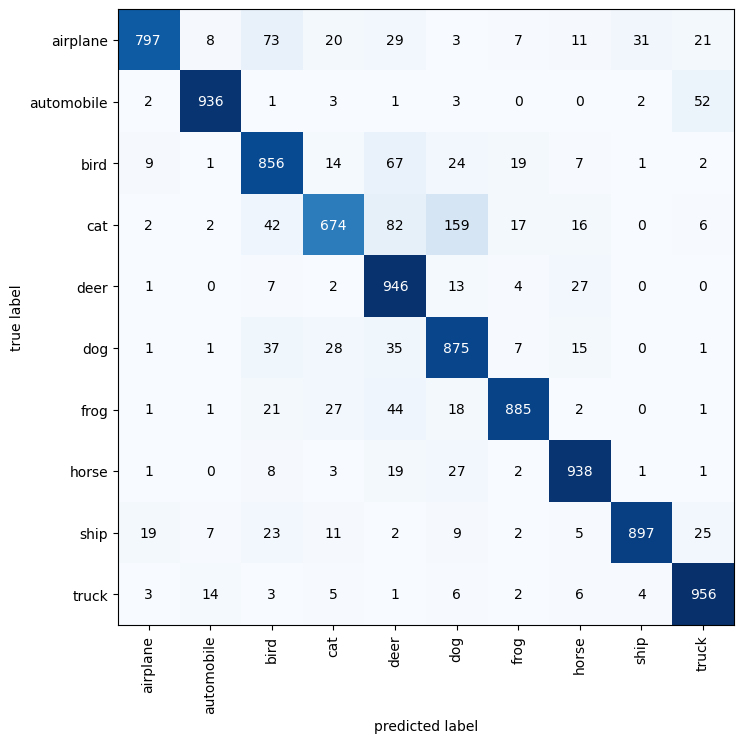

In [25]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 90.625%


<Figure size 2500x400 with 0 Axes>

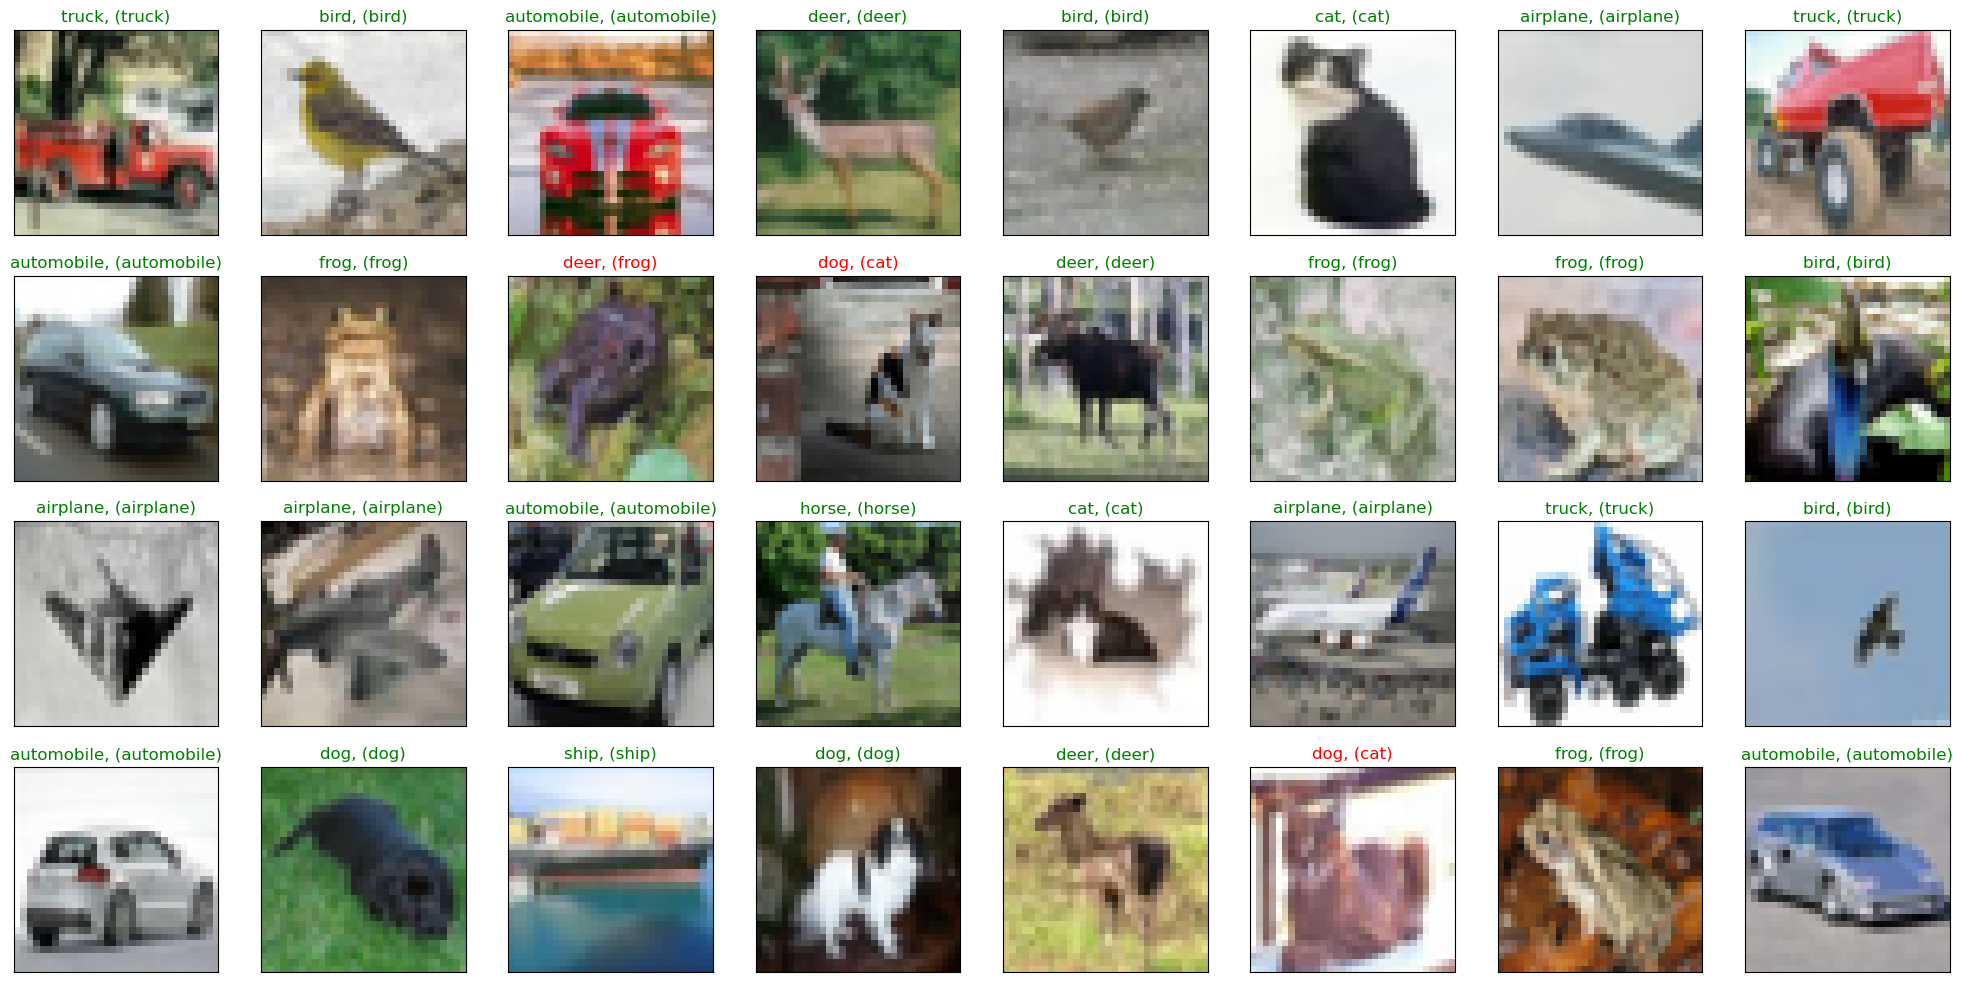

In [27]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

In [29]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Parameters:
        ------------
        tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
        ------------
        Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [31]:
def show_examples(model, data_loader, unnormalizer=None, class_dict=None):
    
        
    for batch_idx, (features, targets) in enumerate(data_loader):

        with torch.no_grad():
            features = features
            targets = targets
            logits = model(features)
            predictions = torch.argmax(logits, dim=1)
        break

    fig, axes = plt.subplots(nrows=3, ncols=5,
                             sharex=True, sharey=True)
    
    if unnormalizer is not None:
        for idx in range(features.shape[0]):
            features[idx] = unnormalizer(features[idx])
    nhwc_img = np.transpose(features, axes=(0, 2, 3, 1))
    
    if nhwc_img.shape[-1] == 1:
        nhw_img = np.squeeze(nhwc_img.numpy(), axis=3)

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhw_img[idx], cmap='binary')
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False

    else:

        for idx, ax in enumerate(axes.ravel()):
            ax.imshow(nhwc_img[idx])
            if class_dict is not None:
                ax.title.set_text(f'P: {class_dict[predictions[idx].item()]}'
                                  f'\nT: {class_dict[targets[idx].item()]}')
            else:
                ax.title.set_text(f'P: {predictions[idx]} | T: {targets[idx]}')
            ax.axison = False
    plt.tight_layout()
    plt.show()

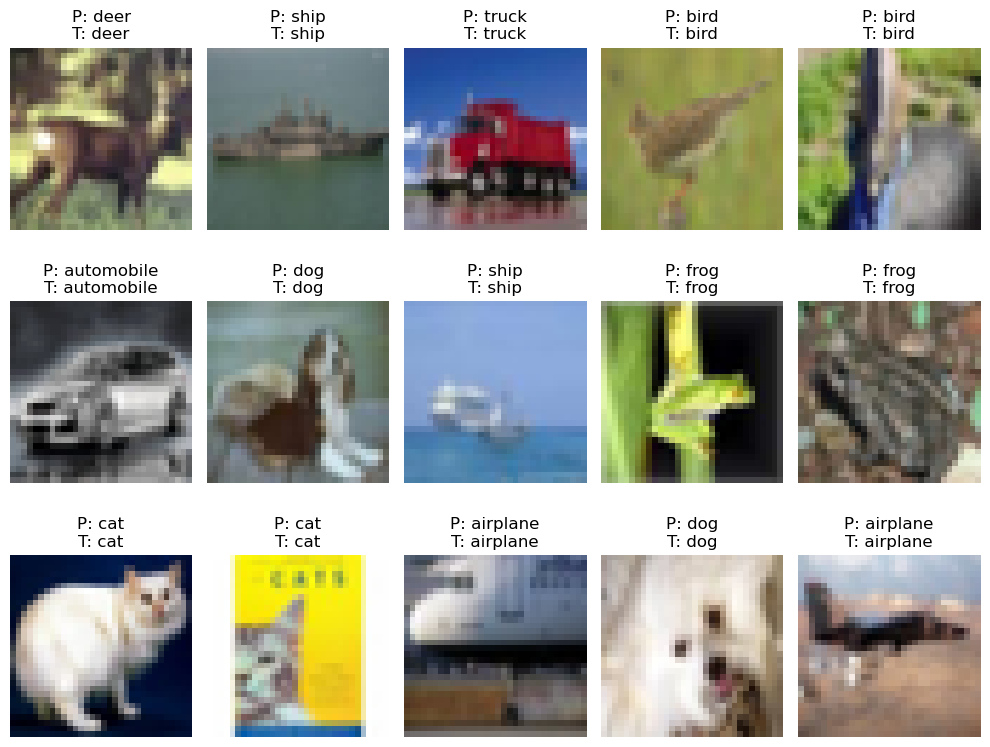

In [32]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)